# About Donorschoose.org


DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.



Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: 
* How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
* How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
* How to focus volunteer time on the applications that need the most assistance</li>
   


The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

## Understand the DonorsChoose Data Set's Attributes

There are two files:   1.train_data.csv(consists 17 features)

                2.resources.csv(consists 4 features)

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### importing all necessary modules

In [1]:
#import all necessary modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors



from tqdm import tqdm
import os

from collections import Counter


from collections import Counter
from sklearn import model_selection  
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

## 1. Reading Data

In [2]:
#load two datafiles into the dataframe
project_data = pd.read_csv('train_data.csv')
resources_data = pd.read_csv('resources.csv')

In [4]:
print("Number of data points in train data", project_data.shape)
print('*'*80)

print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
********************************************************************************
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
#dataframe
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [6]:
#dataframe
resources_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [7]:
#print number of datapoints and columns in resources_data
print('number of datapoints in resources_data:',resources_data.shape)
print("*"*60)
print('total features in resources_data:', resources_data.columns)

number of datapoints in resources_data: (1541272, 4)
************************************************************
total features in resources_data: Index(['id', 'description', 'quantity', 'price'], dtype='object')


**observation:**
* in project data we have 109248 datapoints(rows) and 17 features (columns).
* in resources_data we have 1541272 datapoints and  4 features(columns)

# 2. text preprocessing ( text data& categorical data)

**remove and replace  unwanted symbols, special charecters and words**

In [8]:
catogories = list(project_data['project_subject_categories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [9]:
project_data['clean_proj_categories'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_categories'], axis=1, inplace=True) #remove that previous subject_catogery attribute.

### 2.2 project_grade_category

In [10]:
catogories = list(project_data['project_grade_category'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        j = j.replace(' ','_') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('-','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [11]:
project_data['clean_proj_grade'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_grade_category'], axis=1, inplace=True) #remove that previous grade_catogery attribute.

### 2.3  project_subject_subcategories

In [12]:
catogories = list(project_data['project_subject_subcategories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
lst = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    lst.append(temp.strip())
#lst is list with all cleaned subcategories.

In [13]:
project_data['clean_proj_subcategories'] = lst    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True) #remove that previous subject_subcatogery attribute.

## 2.4 Text Preprocessing
###  Project Essay's

there are we have 4 essays's:
   1.  project_essay_1 
   2.  project_essay_2
   3.  project_essay_3 
   4.  project_essay_4
* so we have to  merge(combilne) 4 essays into one single essay.

In [14]:
# merge all essay columns into single essay columns 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [15]:
#remove that previous project_essay_1,2,3 and 4
project_data.drop(["project_essay_1"], axis=1, inplace=True) 
project_data.drop(["project_essay_2"], axis=1, inplace=True) 
project_data.drop(["project_essay_3"], axis=1, inplace=True) 
project_data.drop(["project_essay_4"], axis=1, inplace=True) 

In [16]:
# to observe the random esssay text data
print(project_data['essay'].values[102])

Hello!, thank you for wanting to learn more about my class! My students are Deaf and Hard-of-Hearing. The ages range from 6-8 years old. They don't have a lot of the life experiences as other students do. Almost all of my class qualifies for free lunch. Some of them ride the bus for over an hour a day (one way) to get to school. I would like to make learning fun and interactive.\r\n\r\nThey don't have access to language as other students. I want my students to become engaged in their learning and be able to interact with it. I can show them pictures in a book but then I have to put the book down so I can sign the story. So they lose the visual. It isn't possible to sign and hold a book at the same time.\r\n\r\nMy classroom is special because my students require a lot of visual aids and pictures.  I would love to show them a video of a whale or show them pictures about what we are learning.This technology would benefit my students so much. They would be able to see the text or book that

**observation**
* In the above essay feature  there are lot of unnecessary  special charecters and some other  words so we have to clean text data

In [17]:
# expand contractions

# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
#english stopwords
import nltk
d = nltk.corpus.stopwords.words('english')
print(set(d))
print(len(d))


{'was', 'at', 'where', 'so', 'wouldn', 'being', 'because', 'o', 'before', 'ain', 'an', 'other', 'were', "doesn't", 'there', 'shan', 'she', 'll', 'yourselves', 'aren', 'hers', 'against', 'nor', 'than', "shouldn't", 'most', "won't", 'them', "wouldn't", 'yourself', 'all', 'hasn', "isn't", 'themselves', 'on', 'do', 'yours', 'why', 'haven', 'over', "weren't", "shan't", "you're", 'who', 'hadn', 'ma', 'only', 'which', 'their', 'such', "aren't", 'shouldn', 'under', 'not', "mightn't", 'few', 'each', 'above', 'its', 'm', 'in', 'my', 'does', 'here', 'needn', 'any', 'wasn', 'but', 'ours', "haven't", 'while', "she's", 'i', 'down', "it's", 'did', 'has', 'mustn', 'mightn', "mustn't", 'will', 'her', 'after', 'if', 'herself', 'him', 'been', 'up', "didn't", 'have', 'same', 'y', 'too', 'doing', 'had', 'they', 'as', 'further', 'until', "hadn't", "needn't", 'both', 'we', 'now', 'having', 'he', 'how', 'just', 'didn', 'ourselves', 'very', 'd', "wasn't", 'these', 're', "don't", 'is', 'won', 'below', 'by', 'th

#### note: we should remove some  words('no', 'nor', 'not') from stop words 

In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 2.3.1 text preprocessing project_essay

In [20]:
#replace & remove some unneccesary words in text

from tqdm import tqdm
preproccessed_essay_text = []
# tqdm is for printing the status bar
for sent in tqdm(project_data['essay'].values):    #all text data in essay feature 
    s = decontracted(sent)                  #function calling for expand contraction words
    s = s.replace('\\r', ' ')                   #replacing \\r with space
    s = s.replace('\\"', ' ')                   #replacing \\"', with space
    s = s.replace('\\n', ' ')                   #replacing \\n with space
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_essay_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:45<00:00, 2394.49it/s]


In [21]:
project_data['preproccessed_essay_text'] = preproccessed_essay_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['essay'], axis=1, inplace=True) #remove that previous essay attribute.

### 3.2.2 Text preprocessing project_Title

In [22]:
# to observe the some random title text data
print(project_data['project_title'].values[12])
print("*"*40)
print(project_data['project_title'].values[1640])
print("*"*40)

Building Life Science Experiences
****************************************
Scientists at Work Need Materials
****************************************


#### text preprocessing project_title

In [23]:
from tqdm import tqdm
preproccessed_title_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):    #all text data in essay feature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_title_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:01<00:00, 56046.82it/s]


In [24]:
project_data['preproccessed_title_text'] = preproccessed_title_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_title'], axis=1, inplace=True) #remove that previous project title attribute.

#### Text preprocessing project_resource_summary

In [25]:
from tqdm import tqdm
preproccessed_resource_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_resource_summary'].values):    #all text data in project_resource_summaryfeature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_resource_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:04<00:00, 23564.76it/s]


In [26]:
project_data['preproccessed_prjct_resource_summary'] = preproccessed_resource_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_resource_summary'], axis=1, inplace=True) #remove that previous resource_text attribute.

## 2.3.4 dataframe after text preprocessed features

In [27]:
#print top 4 data points  after text preprocessed features
project_data.head(4)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,4,1,Literacy_Language Math_Science,Grades_PreK_2,Literacy Mathematics,i work at a unique school filled with both esl...,techie kindergarteners,my students need to engage in reading and math...


## 2.4 Join two dataframe(project_proposal_data and resources_data) based on ID

In [28]:
#to get price of the project
resources_data.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [29]:
#https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
#from resources data  coulumns group by id and sum values of two columns
price_data = resources_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(3)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4


In [30]:
#join(merge) two data frames based on id
project_data = pd.merge(project_data, price_data, on='id', how='left')  #how=lef if any remaining data present in any df that will be merge with dataframe


In [31]:
#shape of the final merged dataframe
project_data.shape

(109248, 16)

we have 109248 datapoints and 16 features

## print final data frame

In [32]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...,516.85,22


### Classlabel

#### we do not consider class label in clustering
#### so that we should seperate class label from  data

In [33]:
label = project_data['project_is_approved']

# 2.7 Creating Data Matrix



# 2.7.1 feature vectorization (TFIDF)

## converting the preproccessed_essay_text to vectors(TFIDF)

* according to the previous assignments we got best AUC  for tfidf vectorizer

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer1 = TfidfVectorizer(min_df=10,ngram_range=(1,2))
tfidf_essaytxt = vectorizer1.fit_transform(project_data['preproccessed_essay_text'].values)

print("*"*60)
print("After vectorizations:")
print(tfidf_essaytxt.shape)

************************************************************
After vectorizations:
(109248, 206074)


## 2.7.2 converting the preproccessed_title_text to vectors(TFIDF)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2))
tfidf_titletxt=vectorizer2.fit_transform(project_data['preproccessed_title_text'].values)

print("*"*60)
print("After vectorizations:")
print(tfidf_titletxt.shape)

************************************************************
After vectorizations:
(109248, 9272)


# 3.0  One-Hot-Encoding Categorical features

**there are 5 categorical features:**
* school state
* clean project subject category
* clean project subject sub category
* project_grade
* teacher prefix


## 3.1 one-hot-encode( schoolstate)

In [36]:
#onehotencoding
vectorizer3 = CountVectorizer()
state_onehot = vectorizer3.fit_transform(project_data['school_state'].values) 

print("*"*60)
print("After  one hot encode vectorizations")
print(state_onehot.shape)

************************************************************
After  one hot encode vectorizations
(109248, 51)


## 3.2 one-hot-encode (clean_proj_categories)

In [37]:
#onehotencoding
vectorizer4 = CountVectorizer()
proj_categories_onehot = vectorizer4.fit_transform(project_data['clean_proj_categories'].values)



print("*"*60)
print("After  one hot encode vectorizations")
print(proj_categories_onehot.shape)

************************************************************
After  one hot encode vectorizations
(109248, 9)


## 3.3 one-hot-encode (clean_proj_subcategories)

In [38]:
#onehotencoding
vectorizer5 = CountVectorizer()
proj_subcategories_onehot = vectorizer5.fit_transform(project_data['clean_proj_subcategories'].values) 

print("*"*60)
print("After  one hot encode vectorizations")
print(proj_subcategories_onehot.shape)

************************************************************
After  one hot encode vectorizations
(109248, 30)


## 3.4 one-hot-encode (clean_proj_grade)

In [39]:
#onehotencoding
vectorizer6 = CountVectorizer()
proj_grade_onehot = vectorizer6.fit_transform(project_data['clean_proj_grade'].values) 


print("*"*60)
print("After  one hot encode vectorizations")
print(proj_grade_onehot .shape)

************************************************************
After  one hot encode vectorizations
(109248, 4)


## 3.5 one-hot-encode (teacher_prefix)

In [40]:
#onehotencoding
#  np.nan is an invalid document, expected byte or unicode string.   https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

vectorizer7 = CountVectorizer()
teacher_prefix_onehot = vectorizer7.fit_transform(project_data['teacher_prefix'].values.astype('U'))

print("*"*60)
print("After  one hot encode vectorizations")
print(teacher_prefix_onehot.shape)

************************************************************
After  one hot encode vectorizations
(109248, 6)


# 4.0  Normalizing Numerical features

**there are 3 numerical features:**
* teacher_number_of_previously_posted_projects
* price
* quantity

## 4.1  Normalizing (teacher_number_of_previously_posted_projects)

In [41]:
from sklearn.preprocessing import Normalizer
normalizer1 = Normalizer()

prvs_posted_prjcts_norm = normalizer1.fit_transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("*"*60)
print("After vectorizations")
print(prvs_posted_prjcts_norm.shape)

************************************************************
After vectorizations
(109248, 1)


## 4.2  Normalizing (price)

In [42]:
from sklearn.preprocessing import Normalizer
normalizer2 = Normalizer()

price_norm = normalizer2.fit_transform(project_data['price'].values.reshape(-1,1))



print("*"*60)
print("After vectorizations")
print(price_norm.shape)


************************************************************
After vectorizations
(109248, 1)


## 4.3  Normalizing (quantity)

In [43]:
from sklearn.preprocessing import Normalizer
normalizer3 = Normalizer()

quantity_norm = normalizer3.fit_transform(project_data['quantity'].values.reshape(-1,1))


print("*"*60)
print("After vectorizations")
print(quantity_norm.shape)


************************************************************
After vectorizations
(109248, 1)


# Creating (data matix):
# <font color='blue'> data matix with all categorical, all numerical,essay(tfidf) and title(tfidf)</font>

In [44]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
data_mtr = hstack((tfidf_essaytxt,tfidf_titletxt,state_onehot,proj_categories_onehot,proj_subcategories_onehot,proj_grade_onehot,teacher_prefix_onehot,prvs_posted_prjcts_norm,price_norm,quantity_norm )).tocsr()

print("*"*60)
print("Final set1 Data matrix:")
print(data_mtr.shape)

************************************************************
Final set1 Data matrix:
(109248, 215449)


**Observation:**
    * we have our final datamarix with  109248 rows(datapoints) and  215449 features

# <font color = 'green'>step 2:</font>
### Choose any of the feature selection/reduction algorithms ex: selectkbest features, pretrained word vectors, model based feature selection etc and reduce the number of features to 5k features

# 2. Feature selection using selectkbest features

* we have to select 5k features

In [45]:
# select top features using sklearn_feature selection,  https://www.kaggle.com/sz8416/6-ways-for-feature-selection
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
from sklearn.feature_selection import SelectKBest, chi2

#selecting 5000 features from  data
#chi-squared stats  used to select max non negetive features
newdata_mtr=SelectKBest(chi2, k=5000).fit_transform(data_mtr,label)


print("*"*60)
print('after select 500 features from set2:')
print(newdata_mtr.shape)

************************************************************
after select 500 features from set2:
(109248, 5000)


In [46]:
newdata_mtr

<109248x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 5191658 stored elements in Compressed Sparse Row format>

#### For memory constraints we are selecting 60248 data points

In [47]:
newdata_mtr1 = newdata_mtr[:60248]
newdata_mtr1.shape

(60248, 5000)

### Assignment

#  <font color = 'blue'>step 3:</font>


### Apply all three kmeans, Agglomerative clustering, DBSCAN

# <font color='blue'>1.  kmeans</font>

##  Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)

1. **n_clusters** = number of clusters


2. **initialize** = k-means++ (select centroids at intitial stage based on  probablity method)


3. **tol** =   old ci(centroid and  ci new centroid) if difference is 0.0001 then terminate 


4. **inertia** is intercluster distance (lower value is better to take) or Sum of squared distances of samples to their closest cluster center

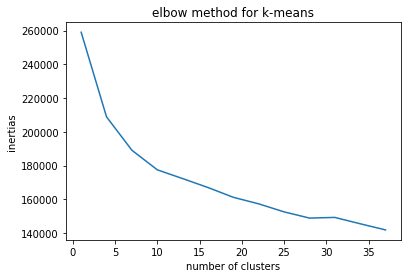

In [72]:
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans

inertias = []

K = range(1,40,3)    # k(clusters) values 1 to 40  with 3 steps 

for i in  (K):
    
    model = KMeans(n_clusters=i, init='k-means++', n_init=2,tol=0.0001, algorithm='auto',n_jobs=-1)
    
    model.fit(newdata_mtr1)    #model fit on data 
    
    inertias.append(model.inertia_)

    
#elbow plot
plt.plot(K,inertias)
plt.title('elbow method for k-means')
plt.xlabel('number of clusters')
plt.ylabel('inertias')
plt.show()

**Observation:**
* y-axis represents: sum of squeres within cluster 
* x-axis represents number of clusters 

**according to the above plot we can choose best number of clusters are 10**


In [47]:
#apply k-mean(with best hyper parameter k value) on our dataset 
from sklearn.cluster import KMeans

model = KMeans(n_clusters = 10,init='k-means++', n_init=4,tol=0.0001, algorithm='auto',n_jobs=-1)
model.fit(newdata_mtr1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=4, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [61]:
# predict the clusters on data
clustrs = model.fit_predict(newdata_mtr1)

clustrs.shape

(60248,)

# Plot the world cloud for essay text(belongs to Cluster 2)

In [68]:
#pre processed essay text
dt =project_data[:60248]       #selecting  top 60248 datapoints 


essay_text= dt['preproccessed_essay_text']
print("shape of the essay_data:",essay_text.shape)

print("shape of the yi's-kmeans:",clustrs.shape)

shape of the essay_data: (60248,)
shape of the yi's-kmeans: (60248,)


In [70]:
#constructing dataframe with essay data
df = pd.DataFrame(essay_text)

#appending model predicted cluster values  to the dataframe
df ['yi_clusters'] = clustrs

df.head(3)

,preproccessed_essay_text,yi_clusters
0,my students are english learners that are work...,8
1,our students arrive to our school eager to lea...,7
2,true champions are not always the ones that wi...,7


In [71]:
#now selection only cluster 2  datapoints
df_cls2 = df [(df['yi_clusters']==2)]

print("dataframe shape:",df_cls2.shape)

df_cls2.head(4)

dataframe shape: (5284, 2)


,preproccessed_essay_text,yi_clusters
13,i teach in a small school district in central ...,2
21,my students walk into school every day full of...,2
31,as a teacher in a low income high poverty scho...,2
56,a lot of people look at my students and see a ...,2


len of cluster 2 essay_text: 8003608


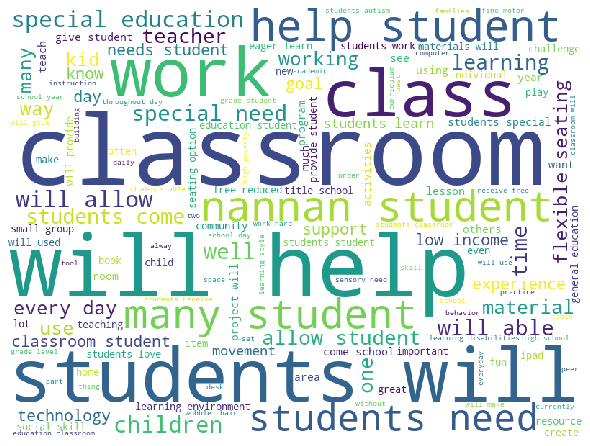

In [72]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_cls2.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of cluster 2 essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

**observation:**
* the above words are mostly often repeated words in essay text(wich are belongs to cluster 2)

## word cloud for cluster 4 essay text

In [80]:
#now selection only cluster 2  datapoints
df_cls6 = df [(df['yi_clusters']==6)]

print("dataframe shape:",df_cls6.shape)

df_cls6.head(4)

dataframe shape: (2170, 2)


,preproccessed_essay_text,yi_clusters
5,i will be moving from 2nd grade to 3rd grade a...,6
6,my students are a dynamic and very energetic g...,6
16,my preschool children ages 3 5 years old with ...,6
28,my students all have a primary diagnosis of au...,6


len of cluster 2 essay_text: 3398480


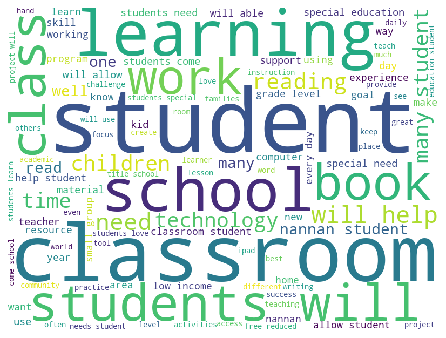

In [81]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_cls6.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of cluster 2 essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## word cloud for cluster 1 essay text

In [82]:
#now selection only cluster 2  datapoints
df_cls1 = df [(df['yi_clusters']==1)]

print("dataframe shape:",df_cls1.shape)

df_cls1.head(4)

dataframe shape: (6527, 2)


,preproccessed_essay_text,yi_clusters
4,our second grade classroom next year will be m...,1
12,my students are always working on new projects...,1
24,this year i am teaching in an efl extended for...,1
25,my students are highly motivated to succeed un...,1


len of cluster 2 essay_text: 9665516


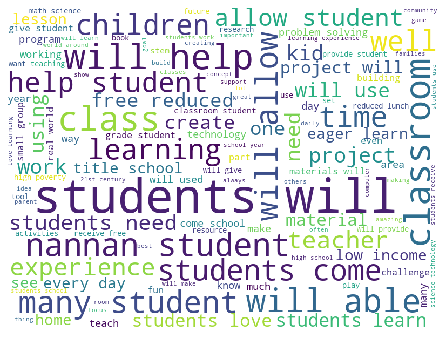

In [83]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_cls1.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of cluster 2 essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# <font color = 'green'>2. Agglomerative Clustering</font>

**instructions:**
    Agglomerative Clustering:
    
● Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.

● You can take less data points (as this is very computationally expensive one) to perform hierarchical clustering because they do take a considerable amount of time to run. 

### Important points:

* Agglomerative clustering is popular technique in **Hirarchial clustering**

* at initial stage evrey point is a Cluster

* in every  next  stage grouping of points will be increses and number of clusters are decreses

* **in agglomerative clustering no  need to give number of clusters  as hyper parameter**

* https://cs.wmich.edu/alfuqaha/summer14/cs6530/lectures/ClusteringAnalysis.pdf
    
* we can easily record the sequence of merges(tree based structure ) from Dendogram of clustering


* Agglommerative clustering works based on Proximity Matrix this implies distance(similarity) bet ween two points

* Proximity methods  based on:
    1. min(distance between points )
    2. Max
    3. group avaragege
    4. Distance between centroids
    

#### we are taking less datapoints because of this agglomerative clustering would take lot of time(to computational)

In [49]:
#we are selecting 20k Datapoints
newdata_mtr2 = newdata_mtr1[:20000]
data= newdata_mtr2.todense()  # dense data is required or agglomerative cluster
data.shape

(20000, 5000)

### 2.1 model with n_clusters = 8

In [65]:
# our data : newdata_mtr1

#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=8, affinity='euclidean', compute_full_tree='auto', linkage='single') #linkage='single' based on  the minimum of the distances between all observations of the two sets

agg_model.fit(data)

# predict the clusters on data
clustrs_yi = agg_model.fit_predict(data)

clustrs_yi

array([1, 1, 1, ..., 1, 1, 1])

In [66]:
#https://www.geeksforgeeks.org/counters-in-python-set-2-accessing-counters/
from collections import Counter 

z = clustrs_yi
col_count = Counter(z) 
print(col_count) 

Counter({1: 19730, 0: 264, 5: 1, 7: 1, 4: 1, 6: 1, 2: 1, 3: 1})


### 2.2 model with n_clusters = 12

In [67]:
# our data : newdata_mtr1

#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=12, affinity='euclidean', compute_full_tree='auto', linkage='single') #linkage='single' based on  the minimum of the distances between all observations of the two sets

agg_model.fit(data)

# predict the clusters on data
clustrs_yi = agg_model.fit_predict(data)

clustrs_yi

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
#https://www.geeksforgeeks.org/counters-in-python-set-2-accessing-counters/
from collections import Counter 

z = clustrs_yi
col_count = Counter(z) 
print(col_count) 

Counter({0: 19727, 1: 263, 11: 1, 10: 1, 9: 1, 8: 1, 7: 1, 4: 1, 6: 1, 5: 1, 2: 1, 3: 1})


### 2.3 model with n_clusters = 16

In [69]:
# our data : newdata_mtr1

#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=16, affinity='euclidean', compute_full_tree='auto', linkage='single') #linkage='single' based on  the minimum of the distances between all observations of the two sets

agg_model.fit(data)

# predict the clusters on data
clustrs_yi = agg_model.fit_predict(data)

clustrs_yi

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
#we can observe houmany datapoints belongs to each cluster
#https://www.geeksforgeeks.org/counters-in-python-set-2-accessing-counters/
from collections import Counter 

z = clustrs_yi
col_count = Counter(z) 
print(col_count) 

Counter({0: 19723, 1: 263, 11: 1, 10: 1, 9: 1, 8: 1, 12: 1, 15: 1, 13: 1, 4: 1, 7: 1, 14: 1, 6: 1, 5: 1, 2: 1, 3: 1})


### predicted clusters 

In [86]:
lbl_clstrs = agg_model.fit_predict(data)

# 2.4 Plot the world cloud for essay text(belongs to Cluster 2)

In [92]:
#pre processed essay text
dt =project_data[:60248]       #selecting  top 60248 datapoints 


essay_text= dt['preproccessed_essay_text']
essay_text = essay_text[:20000] #selecting 2000 points
print("shape of the essay_data:",essay_text.shape)



shape of the essay_data: (20000,)


In [93]:
#constructing dataframe with essay data
df = pd.DataFrame(essay_text)

#appending model predicted cluster values  to the dataframe
df ['yi_clusters'] = lbl_clstrs

df.head(3)

,preproccessed_essay_text,yi_clusters
0,my students are english learners that are work...,0
1,our students arrive to our school eager to lea...,0
2,true champions are not always the ones that wi...,0


### 2.4.1 word cloud for cluster 0 words

In [94]:
#now selection only cluster 2  datapoints
df_cls2 = df [(df['yi_clusters']==0)]

print("dataframe shape:",df_cls2.shape)

df_cls2.head(4)

dataframe shape: (19723, 2)


,preproccessed_essay_text,yi_clusters
0,my students are english learners that are work...,0
1,our students arrive to our school eager to lea...,0
2,true champions are not always the ones that wi...,0
3,i work at a unique school filled with both esl...,0


#### we can observe essay text data of cluster 0 then we could deside reviews of  cluster 0 are positive reviews or negetive reviews.

In [97]:
print(df_cls2['preproccessed_essay_text'][4])

our second grade classroom next year will be made up of around 25 kids many of them coming from spanish speaking families many of them receive free or reduced priced lunch these are inquisitive students who often do not have as many educational resources at home as they need these kids are curious about the world excited to learn and ready to find out all that an education can offer them i am excited to teach them and push them to meet and exceed any expectations they have of themselves for many students math is a subject that does not pertain to life a subject that stresses them out i believe in making math not only fun but also important to their lives a typical part of the day is our calendar math section which is a time in which we talk about the calendar the weather and about the properties of the day these calendar math journals will allow each student to be more accountable for their own learning it will help them in paying attention and to be more involved during this time stud

len of cluster 2 essay_text: 29344440


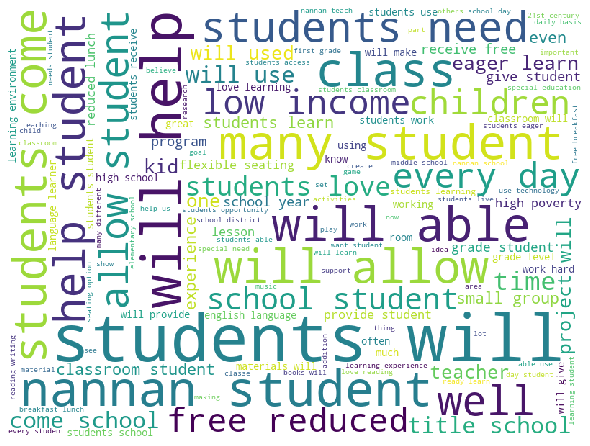

In [95]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_cls2.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of cluster 2 essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

### 2.4.2 word cloud for cluster 1 words

In [98]:
#now selection only cluster 2  datapoints
df_cls1 = df [(df['yi_clusters']==1)]

print("dataframe shape:",df_cls1.shape)

df_cls1.head(4)

dataframe shape: (263, 2)


,preproccessed_essay_text,yi_clusters
47,our students work so hard to be the best leade...,1
248,what time is it how much longer until lunch th...,1
287,my fun feisty fearless first graders are amazi...,1
503,our school has a high population of economical...,1


#### we can observe essay text data of cluster 0 then we could deside reviews of  cluster 0 are positive reviews or negetive reviews.

In [101]:
print(df_cls1['preproccessed_essay_text'][248])

what time is it how much longer until lunch this is a daily question asked in my classroom the students of our inner city school have immigrant parents of a low socio economic status parents often work two jobs so students are often latchkey kids or watched by grandparents they are english language learners we are a title i school all of our students qualify for the free meal program research shows that fulfilling basic life essential needs such as clean clothes and having enough to eat can help a child succeed in school i want my students to have their basic needs met i am requesting life essentials for my students the weather has changed the rainy season and cold season are coming upon us combined with the fact that this upcoming season may also be abnormally harsher my students need these life essentials to be protected once they exit both the classroom and their homes ultimately a hoodie a new shirt umbrella or rain boots can bring happiness and health to these deserving individual

len of cluster 2 essay_text: 375497


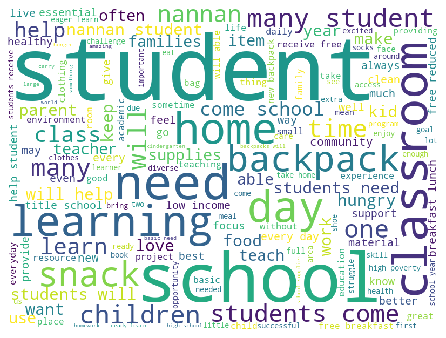

In [102]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_cls1.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of cluster 2 essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# <font color = 'blue'>3. DBSCAN Clustering:</font>

## 3.1 Find the best ‘eps’ using the elbow-knee method.

###  take a smaller sample size for this as well.

#### Important points:

1. **density based clustering:**
    * dense regions: clusters
    * sparse regions: noise points
        
        
2. **measure density?**

    * there are some key points : Min pts, eps, core points, border points and noise points
        
3. Min pts and eps are hyper parameters

In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
#  https://www.youtube.com/watch?v=TGad0nc-8gU

from sklearn.neighbors  import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=14,algorithm='brute')  #knn model using bruteforce algorithm

nbrs.fit(newdata_mtr2)   #model fitr on data

distances, indices = nbrs.kneighbors()   #return distances with datapoints indices 

distances = np.sort(distances, axis = 0)  # sort all distances values 

distances = distances[:,1]



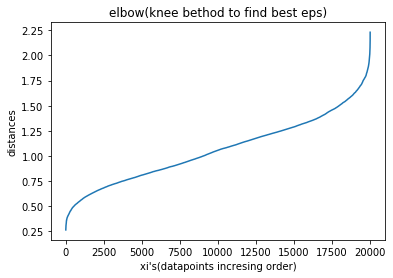

In [110]:
plt.plot(distances)
plt.title('elbow(knee bethod to find best eps)')
plt.xlabel("xi's(datapoints incresing order)")
plt.ylabel('distances')
plt.show()

**observation:**
    * according to the above plot we can take 1.50 is our best eps value

### 4.2 DBSCAN Clustering

### 1. eps = 1.5 , min_samples = 20

In [60]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

from sklearn.cluster import DBSCAN

dbscan_model4 = DBSCAN(eps=1.5, min_samples=20, metric='euclidean', algorithm='auto',  n_jobs=-1) 
dbscan_model4.fit(data)

# predict the clusters on data
clustrs_yi4 = dbscan_model.fit_predict(data)

clustrs_yi4

array([ 0, -1, -1, ..., -1, -1, -1])

In [61]:
#we can observe houmany datapoints belongs to each cluster
#https://www.geeksforgeeks.org/counters-in-python-set-2-accessing-counters/
from collections import Counter 

z = clustrs_yi4
col_count = Counter(z) 
print(col_count) 

Counter({-1: 14017, 0: 5983})


### 2. eps = 1.5 , min_samples = 60

In [58]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

from sklearn.cluster import DBSCAN

dbscan_model3 = DBSCAN(eps=1.5, min_samples=60, metric='euclidean', algorithm='auto',  n_jobs=-1) 
dbscan_model3.fit(data)

# predict the clusters on data
clustrs_yi3 = dbscan_model.fit_predict(data)

clustrs_yi3

array([ 0, -1, -1, ..., -1, -1, -1])

In [59]:
#we can observe houmany datapoints belongs to each cluster
#https://www.geeksforgeeks.org/counters-in-python-set-2-accessing-counters/
from collections import Counter 

z = clustrs_yi3
col_count = Counter(z) 
print(col_count) 

Counter({-1: 14017, 0: 5983})


### 3. eps = 1.5 , min_samples = 100

In [54]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=1.5, min_samples=100, metric='euclidean', algorithm='auto',  n_jobs=-1) 
dbscan_model.fit(data)

# predict the clusters on data
clustrs_yi2 = dbscan_model.fit_predict(data)

clustrs_yi2

array([ 0, -1, -1, ..., -1, -1, -1])

In [64]:
#we can observe houmany datapoints belongs to each cluster
#https://www.geeksforgeeks.org/counters-in-python-set-2-accessing-counters/
from collections import Counter 

z = clustrs_yi2
col_count = Counter(z) 
print(col_count) 

Counter({-1: 14017, 0: 5983})


# 4.3 Plot the world cloud for essay text(belongs to Cluster 2)

In [65]:
#pre processed essay text
dt =project_data[:60248]       #selecting  top 60248 datapoints 


essay_text= dt['preproccessed_essay_text']
essay_text = essay_text[:20000] #selecting 2000 points
print("shape of the essay_data:",essay_text.shape)



shape of the essay_data: (20000,)


In [67]:
#constructing dataframe with essay data
df = pd.DataFrame(essay_text)

#appending model predicted cluster values  to the dataframe
df ['yi_clusters'] = clustrs_yi2

df.head(3)

,preproccessed_essay_text,yi_clusters
0,my students are english learners that are work...,0
1,our students arrive to our school eager to lea...,-1
2,true champions are not always the ones that wi...,-1


### 4.3.1 word cloud for cluster 0 words

In [68]:
#now selection only cluster 2  datapoints
df_cls2 = df [(df['yi_clusters']==0)]

print("dataframe shape:",df_cls2.shape)

df_cls2.head(4)

dataframe shape: (5983, 2)


,preproccessed_essay_text,yi_clusters
0,my students are english learners that are work...,0
3,i work at a unique school filled with both esl...,0
4,our second grade classroom next year will be m...,0
8,my students are enthusiastic and inquisitive l...,0


#### we can observe essay text data of cluster 0 then we could deside reviews of  cluster 0 are positive reviews or negetive reviews.

In [70]:
print(df_cls2['preproccessed_essay_text'][3])

i work at a unique school filled with both esl english as a second language and high poverty students our students have individual personal struggles that would break your heart but once you step through the doors you would not notice anything but their positive and resilient attitude for learning my students love and support each other through every aspect of their learning journey we have students from all over the world speaking 77 different languages and we are like family every student is welcomed with open arms regardless of where they come from or what language they speak education and love have a universal language and in my classroom we have plenty of both my students live in high poverty conditions with limited to no access to technology ipads provide the opportunity to learn through playing reading and math games that engage and inspire these ipads will surely be the hottest commodity in my classroom as students will beg to get on to play these educational games i will be tr

len of cluster 2 essay_text: 8639129


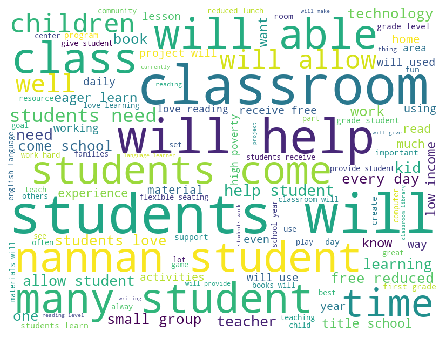

In [71]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_cls2.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of cluster 2 essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

### 4.3.2 word cloud for cluster 1 words

In [74]:
#now selection only cluster 2  datapoints
df_cls1 = df [(df['yi_clusters']==-1)]

print("dataframe shape:",df_cls1.shape)

df_cls1.head(4)

dataframe shape: (14017, 2)


,preproccessed_essay_text,yi_clusters
1,our students arrive to our school eager to lea...,-1
2,true champions are not always the ones that wi...,-1
5,i will be moving from 2nd grade to 3rd grade a...,-1
6,my students are a dynamic and very energetic g...,-1


#### we can observe essay text data of cluster -1 then we could deside reviews of  cluster -1 are positive reviews or negetive reviews.

In [76]:
print(df_cls1['preproccessed_essay_text'][6])

my students are a dynamic and very energetic group of middle schoolers they also generally come from a low socioeconomic background and as a result often do not have access to the supplies and opportunities of other middle schoolers in the state i have seen their excitement as they master a new skill that they were previously unable to accomplish they love using technology and respond well to computer based programs they are deserving kids that just need opportunities to succeed my students are an engaging and active group of kids that struggle with basic reading and writing they daily use a well researched reading program called read 180 this program necessitates daily computer work while the school has a computer lab it does not have an adequate number of computers that can run the read 180 reading program in addition to this many of the computers are shared with the rest of the school so we do not always have the access that we need we are also in need of additional computers for th

len of cluster 2 essay_text: 21103653


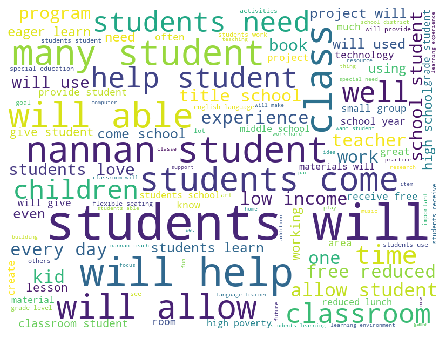

In [77]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_cls1.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of cluster 2 essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Summary(conclusion):

1. initially we took   dataset  without class label.
2. we did perform preprocessing and vectorization (tfidf on text data),
3. we have selected top 5000 features by using seleckBestk method
4. then we have performed k-means clustering using k-means++ algorithm
    * k-means clustering centroid based algorithm
    * we have find best k(number of clusters using elbow(knee)) method
    * after performing k-means clustering we could observe clusters
5.  after k-means clustering we have  performed Hirachial clustering(agglomerative clustering technique)
    * agglomerative clustering performed based on similarity matrix(proximity matrix)
    * similarity between points (linkage = single(Min distence between points in clusters ))
6. aftern hirachial clustering we have  performed DBSCAN clustering
    * DBSCAN is density basede  clustering
    * density measured by Min pts,epsilon, core points, border points,and including presence of Noise points
    * we have selected right epsilon value by doing  elbow(knee method)
    * then after performing the DBSCAN we could observe clusters 

# Summary in Tabular form
### all results summarized in the tabular form

In [4]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
a = PrettyTable()
a.field_names = ["Clustering Technique(algorithm)","n_clusters","best_epsilon","Method"]

a.add_row(["K-Means", 10,"-","k-Means++"])
a.add_row(["Agglomerative clustering", 8,"-","Min Distance"])
a.add_row(["DBSCAN", 2,1.5,"auto" ])

print(a)

+---------------------------------+------------+--------------+--------------+
| Clustering Technique(algorithm) | n_clusters | best_epsilon |    Method    |
+---------------------------------+------------+--------------+--------------+
|             K-Means             |     10     |      -       |  k-Means++   |
|     Agglomerative clustering    |     8      |      -       | Min Distance |
|              DBSCAN             |     2      |     1.5      |     auto     |
+---------------------------------+------------+--------------+--------------+
